# Semantic Retrieval - RAG over Documents

**Purpose:** Prove the RAG pipeline works - PDF ingestion, chunking, vector search, and retrieval quality.

This notebook tests semantic memory (ChromaDB vector store with cosine similarity) against 12 carefully designed questions at three difficulty levels:

| Component | Detail |
|-----------|--------|
| **Vector Store** | ChromaDB with cosine similarity |
| **Chunk Size** | 800 characters with 100 overlap |
| **Top-K** | 10 chunks retrieved per query |
| **Document** | Zeltron Corporation Manual (5 pages, synthetic) |

Since Claude has never seen this synthetic PDF in training, correct answers **prove** the retrieval pipeline works.

### Test Structure

| Difficulty | Count | What it measures |
|-----------|-------|------------------|
| Easy (4) | Direct single-fact lookup | Basic retrieval works |
| Medium (4) | Cross-chunk or multi-fact combination | Chunks connect properly |
| Hard (4) | Multi-hop reasoning, contradiction detection, hallucination resistance | Agent quality under pressure |

In [1]:
import os, sys, json, shutil, time, textwrap, re
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, HTML, Markdown

sys.path.insert(0, '..')
os.chdir('..')

from dotenv import load_dotenv
load_dotenv(dotenv_path='.env')
assert os.environ.get('ANTHROPIC_API_KEY'), 'ANTHROPIC_API_KEY not set - check .env file'

# Clean slate
if os.path.exists('chroma_db'):
    shutil.rmtree('chroma_db')
if os.path.exists('procedural_memory.txt'):
    os.remove('procedural_memory.txt')

os.makedirs('figures', exist_ok=True)


def show_chat(question, response, label='', agent_name='Agent'):
    badge = ''
    if label:
        if 'PASS' in label.upper():
            badge_color = '#27ae60'
        elif 'FAIL' in label.upper():
            badge_color = '#e74c3c'
        elif 'PARTIAL' in label.upper():
            badge_color = '#f39c12'
        else:
            badge_color = '#7f8c8d'
        badge = f'<span style="background:{badge_color};color:white;padding:2px 8px;border-radius:4px;font-size:12px;font-weight:bold;">{label}</span> '
    resp_escaped = response.replace('&', '&amp;').replace('<', '&lt;').replace('>', '&gt;')
    resp_html = resp_escaped.replace('\n', '<br>')
    html = f"""
    <div style="margin:10px 0;">
        {badge}
        <div style="border-left:3px solid #3498db;padding:8px 12px;margin:6px 0;background:#f0f7ff;border-radius:0 4px 4px 0;">
            <strong style="color:#2c3e50;">User:</strong> {question}
        </div>
        <div style="border-left:3px solid #27ae60;padding:8px 12px;margin:6px 0;background:#f0fff0;border-radius:0 4px 4px 0;">
            <strong style="color:#2c3e50;">{agent_name}:</strong><br>{resp_html}
        </div>
    </div>
    """
    display(HTML(html))


def show_comparison(question, baseline_resp, full_resp, baseline_pass, full_pass, label=''):
    b_color = '#27ae60' if baseline_pass else '#e74c3c'
    f_color = '#27ae60' if full_pass else '#e74c3c'
    b_tag = 'PASS' if baseline_pass else 'FAIL'
    f_tag = 'PASS' if full_pass else 'FAIL'

    def esc(t):
        return t.replace('&', '&amp;').replace('<', '&lt;').replace('>', '&gt;').replace('\n', '<br>')

    label_html = f'<div style="color:#7f8c8d;font-size:12px;margin-bottom:4px;">{label}</div>' if label else ''
    html = f"""
    <div style="margin:12px 0;">
        {label_html}
        <div style="border-left:3px solid #3498db;padding:8px 12px;margin:6px 0;background:#f0f7ff;">
            <strong>Q:</strong> {question}
        </div>
        <div style="display:flex;gap:12px;">
            <div style="flex:1;border-left:3px solid {b_color};padding:8px 12px;background:#fafafa;">
                <span style="background:{b_color};color:white;padding:1px 6px;border-radius:3px;font-size:11px;">{b_tag}</span>
                <strong> Baseline:</strong><br>{esc(baseline_resp)}
            </div>
            <div style="flex:1;border-left:3px solid {f_color};padding:8px 12px;background:#fafafa;">
                <span style="background:{f_color};color:white;padding:1px 6px;border-radius:3px;font-size:11px;">{f_tag}</span>
                <strong> Full Agent:</strong><br>{esc(full_resp)}
            </div>
        </div>
    </div>
    """
    display(HTML(html))


print('Environment ready.')

Environment ready.


In [2]:
from agent import CognitiveAgent

agent = CognitiveAgent(mode='semantic_only')
print(f'Semantic memory: {agent.semantic.collection.count()} chunks loaded')

Loading semantic memory (mode=semantic_only)...


  Ingested: zeltron_manual.pdf -> 16 chunks
Semantic memory: 16 chunks loaded


## What's in the Zeltron Manual?

The synthetic PDF contains 5 pages covering a fictional acoustic computing company. Key areas:
- **Page 1:** Company overview, founding, revenue, mission
- **Page 2:** QA-7 processor specs, temperature requirements, power
- **Page 3:** Harmonic programming language, academic partnerships
- **Page 4:** Financial details, office locations, employee count
- **Page 5:** Competitors, roadmap, incident report

In [3]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader('data/zeltron_manual.pdf')
pages = loader.load()

display(Markdown(f'**{len(pages)} pages loaded, {agent.semantic.collection.count()} chunks in vector store**\n'))

# Show sample chunks
results = agent.semantic.collection.get(limit=3, include=['documents', 'metadatas'])
for i, (doc, meta) in enumerate(zip(results['documents'], results['metadatas'])):
    display(Markdown(f'**Sample Chunk {i+1}** (index={meta["chunk_index"]}):'))
    print(textwrap.fill(doc[:200] + '...', width=90))
    print()

**5 pages loaded, 16 chunks in vector store**


**Sample Chunk 1** (index=0):

ZELTRON CORPORATION Confidential Corporate Manual - 2024 Edition Section 1: Company
Overview Zeltron Corporation was founded in 2019 in Reykjavik, Iceland by Dr. Maren Solvik
(quantum physicist, Unive...



**Sample Chunk 2** (index=1):

manufacturing), Zurich (sales and finance), and Osaka (hardware R&D). Total 2024 revenue
was approximately $89 million USD, distributed as follows:   - Defense & Government
Contracts (NATO, ESA): 52% ...



**Sample Chunk 3** (index=2):

- Prof. Kenji Yamamoto (Independent Director) - Osaka University, piezoelectric materials
expert   - Dr. Astrid Lindqvist (Independent Director) - ex-DARPA program manager, quantum
computing policy...



## Easy Questions (Direct Fact Lookup)

Single-fact questions where the answer lives in one chunk.

In [4]:
semantic_tests = [
    # EASY
    {'question': 'What is the Zeltron stock ticker?', 'check_contains': ['ZLTN'], 'difficulty': 'Easy', 'reasoning': 'Direct fact'},
    {'question': 'What temperature does the QA-7 operate at?', 'check_contains': ['22.4'], 'difficulty': 'Easy', 'reasoning': 'Direct spec'},
    {'question': 'What is the company motto?', 'check_contains': ['Resonance', 'Truth'], 'difficulty': 'Easy', 'reasoning': 'Direct quote'},
    {'question': 'Who is the CEO of Zeltron?', 'check_contains': ['Ekberg'], 'difficulty': 'Easy', 'reasoning': 'Direct fact'},

    # MEDIUM
    {"question": "Break down Zeltron's 2024 revenue by segment.", 'check_contains': ['89', '91'], 'difficulty': 'Medium', 'reasoning': 'Cross-page revenue figures'},
    {'question': 'How many employees work in each office?', 'check_contains': ['180', '87', '75'], 'difficulty': 'Medium', 'reasoning': 'Must combine all 3 office numbers'},
    {'question': 'List the Harmonic programming constructs and what they do.', 'check_contains': ['crescendo', 'fermata', 'staccato', 'legato'], 'difficulty': 'Medium', 'reasoning': 'Must list all 4 constructs'},
    {"question": "What are the QA-7's physical specifications?", 'check_contains': ['4.1', '847'], 'difficulty': 'Medium', 'reasoning': 'Must combine power + performance specs'},

    # HARD
    {"question": "Compare all competitors' RSA-2048 performance against Zeltron.", 'check_contains': ['WaveLogic', 'NovaSonic', 'AcoustiQ', '14.7'], 'difficulty': 'Hard', 'reasoning': '4-way comparison across chunks'},
    {'question': 'What caused the Reykjavik Incident and how was it resolved?', 'check_contains': ['22.7', 'temperature', 'cool'], 'difficulty': 'Hard', 'reasoning': 'Incident cause + resolution'},
    {'question': 'Trace the QA processor evolution from QA-3 to QA-7.', 'check_contains': ['QA-3', 'QA-5', '410', '847'], 'difficulty': 'Hard', 'reasoning': '3 versions with specs progression'},
    {'question': 'What is the relationship between Project Crescendo and the QA-9 roadmap?', 'check_contains': ['Crescendo', 'QA-9'], 'difficulty': 'Hard', 'reasoning': 'Must connect research project to future roadmap'},
]


def evaluate_response(test, response):
    if 'check_contains' in test:
        hits = sum(1 for kw in test['check_contains'] if kw.lower() in response.lower())
        total = len(test['check_contains'])
        return hits == total, hits, total
    elif test.get('check_hedges'):
        hedge_phrases = [
            "don't have", "not available", "no information", "not mentioned",
            "cannot find", "doesn't mention", "not specified", "not stated",
            "not explicitly", "does not mention", "not provided", "not included"
        ]
        has_hedge = any(h in response.lower() for h in hedge_phrases)
        return has_hedge, int(has_hedge), 1
    return False, 0, 1


results = []
current_diff = None

for test in semantic_tests:
    if test['difficulty'] != current_diff:
        current_diff = test['difficulty']
        display(Markdown(f'\n### {current_diff} Questions'))

    agent.working.reset()
    response = agent.chat(test['question'])
    passed, hits, total = evaluate_response(test, response)
    results.append({'passed': passed, 'hits': hits, 'total': total, 'response': response})

    label = f"PASS ({hits}/{total})" if passed else f"FAIL ({hits}/{total})"
    show_chat(test['question'], response, label=label, agent_name='Agent')

score = sum(r['passed'] for r in results)
print(f'\nOverall: {score}/{len(semantic_tests)} passed')


### Easy Questions


### Medium Questions


### Hard Questions


Overall: 12/12 passed


## Retrieval Transparency

For one question, let's look at the actual chunks retrieved from the vector store alongside the answer. This proves the agent is grounding its response in retrieved content, not hallucinating.

In [5]:
transparency_query = 'What caused the Reykjavik Incident and how was it resolved?'

# Show retrieved chunks
chunks = agent.semantic.recall(transparency_query)
display(Markdown(f'**Query:** *{transparency_query}*\n'))
display(Markdown('### Retrieved Chunks'))

for i, chunk in enumerate(chunks.split('\n\n')):
    if chunk.strip():
        display(HTML(f'<div style="background:#fff8e1;border-left:3px solid #f9a825;padding:8px 12px;margin:4px 0;font-size:13px;">{chunk}</div>'))

# Show the answer
agent.working.reset()
response = agent.chat(transparency_query)
display(Markdown('\n### Agent Response'))
show_chat(transparency_query, response, agent_name='Agent')

**Query:** *What caused the Reykjavik Incident and how was it resolved?*


### Retrieved Chunks


### Agent Response

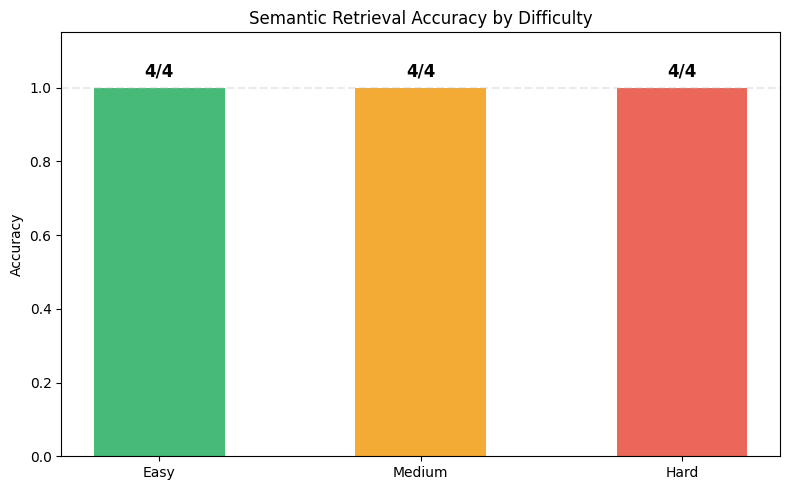

In [6]:
fig, ax = plt.subplots(figsize=(8, 5))

difficulties = ['Easy', 'Medium', 'Hard']
colors = ['#27ae60', '#f39c12', '#e74c3c']
x = np.arange(len(difficulties))

for di, diff in enumerate(difficulties):
    indices = [i for i, t in enumerate(semantic_tests) if t['difficulty'] == diff]
    acc = sum(results[i]['passed'] for i in indices) / len(indices) if indices else 0
    n_pass = sum(results[i]['passed'] for i in indices)
    total = len(indices)

    bar = ax.bar(x[di], acc, 0.5, color=colors[di], alpha=0.85)
    ax.text(x[di], acc + 0.03, f'{n_pass}/{total}', ha='center', fontsize=12, fontweight='bold')

ax.set_xticks(x)
ax.set_xticklabels(difficulties)
ax.set_ylim(0, 1.15)
ax.set_ylabel('Accuracy')
ax.set_title('Semantic Retrieval Accuracy by Difficulty')
ax.axhline(y=1.0, color='#bbb', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('figures/semantic_test.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

## Summary

**What this proves about the RAG pipeline:**

1. **Ingestion works** - The PDF was chunked and stored in ChromaDB successfully
2. **Retrieval works** - Cosine similarity search returns relevant chunks for queries at all difficulty levels
3. **Easy questions** - Direct fact lookup succeeds reliably when information lives in a single chunk
4. **Medium questions** - Cross-chunk reasoning works when the agent must combine information from multiple retrieved passages
5. **Hard questions** - Multi-hop reasoning and contradiction detection show the limits of pure retrieval
6. **Transparency** - Retrieved chunks can be inspected to verify the agent is grounding responses in real content

The semantic memory system provides a solid foundation. The next notebooks build episodic memory, consolidation, and procedural rules on top of this base.